# Importing the relevant libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Data Preprocessing

### Importing the Database

In [2]:
filename = 'ml_datasource.csv'
raw_data = pd.read_csv(filename)
raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [3]:
data = raw_data.copy()
data

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0
...,...,...,...,...,...,...,...,...
17756,EG,0,0.8,1,0,0,0.00,0
17757,IN,0,0.1,1,0,0,0.00,0
17758,CM,0,7.8,1,0,0,0.00,0
17759,CA,0,10.4,1,0,0,0.00,0


### Removing Outliers

In [4]:
sns.set()

<Axes: xlabel='minutes_spent_on_exams', ylabel='Density'>

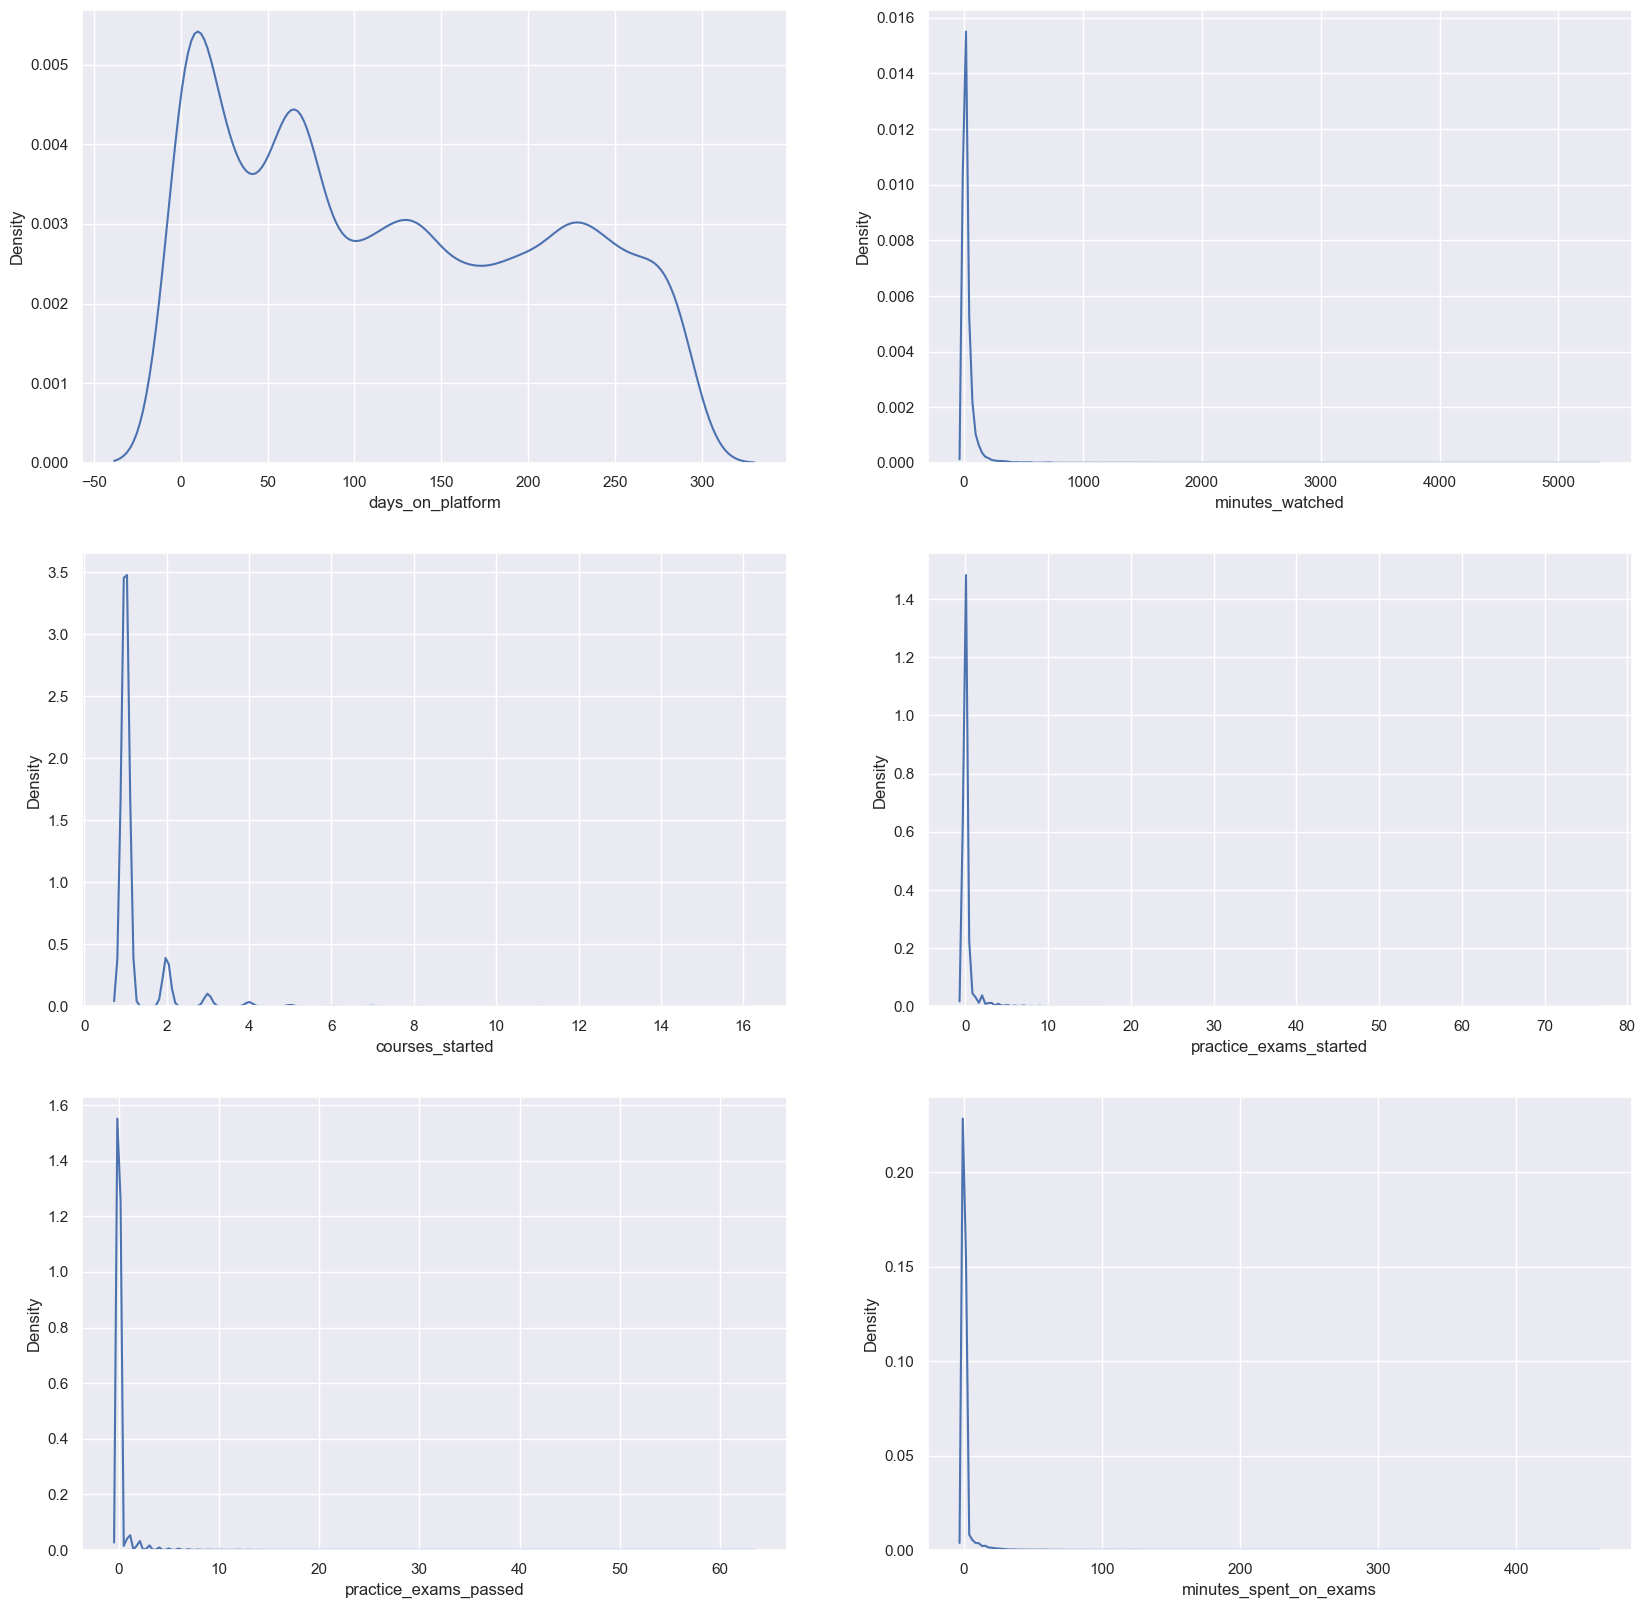

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
sns.kdeplot(data = data, x='days_on_platform', ax=axes[0,0])
sns.kdeplot(data = data, x='minutes_watched', ax=axes[0,1])
sns.kdeplot(data = data, x='courses_started', ax=axes[1,0])
sns.kdeplot(data = data, x='practice_exams_started', ax=axes[1,1])
sns.kdeplot(data = data, x='practice_exams_passed', ax=axes[2,0])
sns.kdeplot(data = data, x='minutes_spent_on_exams', ax=axes[2,1])

In [6]:
# Create Boolean filters for outliers in specific columns
outliers_mins = data['minutes_watched'] > 1000
outliers_courses = data['courses_started'] > 10
outliers_exams = data['practice_exams_started'] > 10
outliers_spent = data['minutes_spent_on_exams'] > 40

# Combine outlier filters (using logical OR)
combined_outliers = outliers_mins | outliers_courses | outliers_exams | outliers_spent

# Filter DataFrame to exclude outliers (logical AND of all negations)
data_no_outliers = data[~combined_outliers]

<Axes: xlabel='minutes_spent_on_exams', ylabel='Density'>

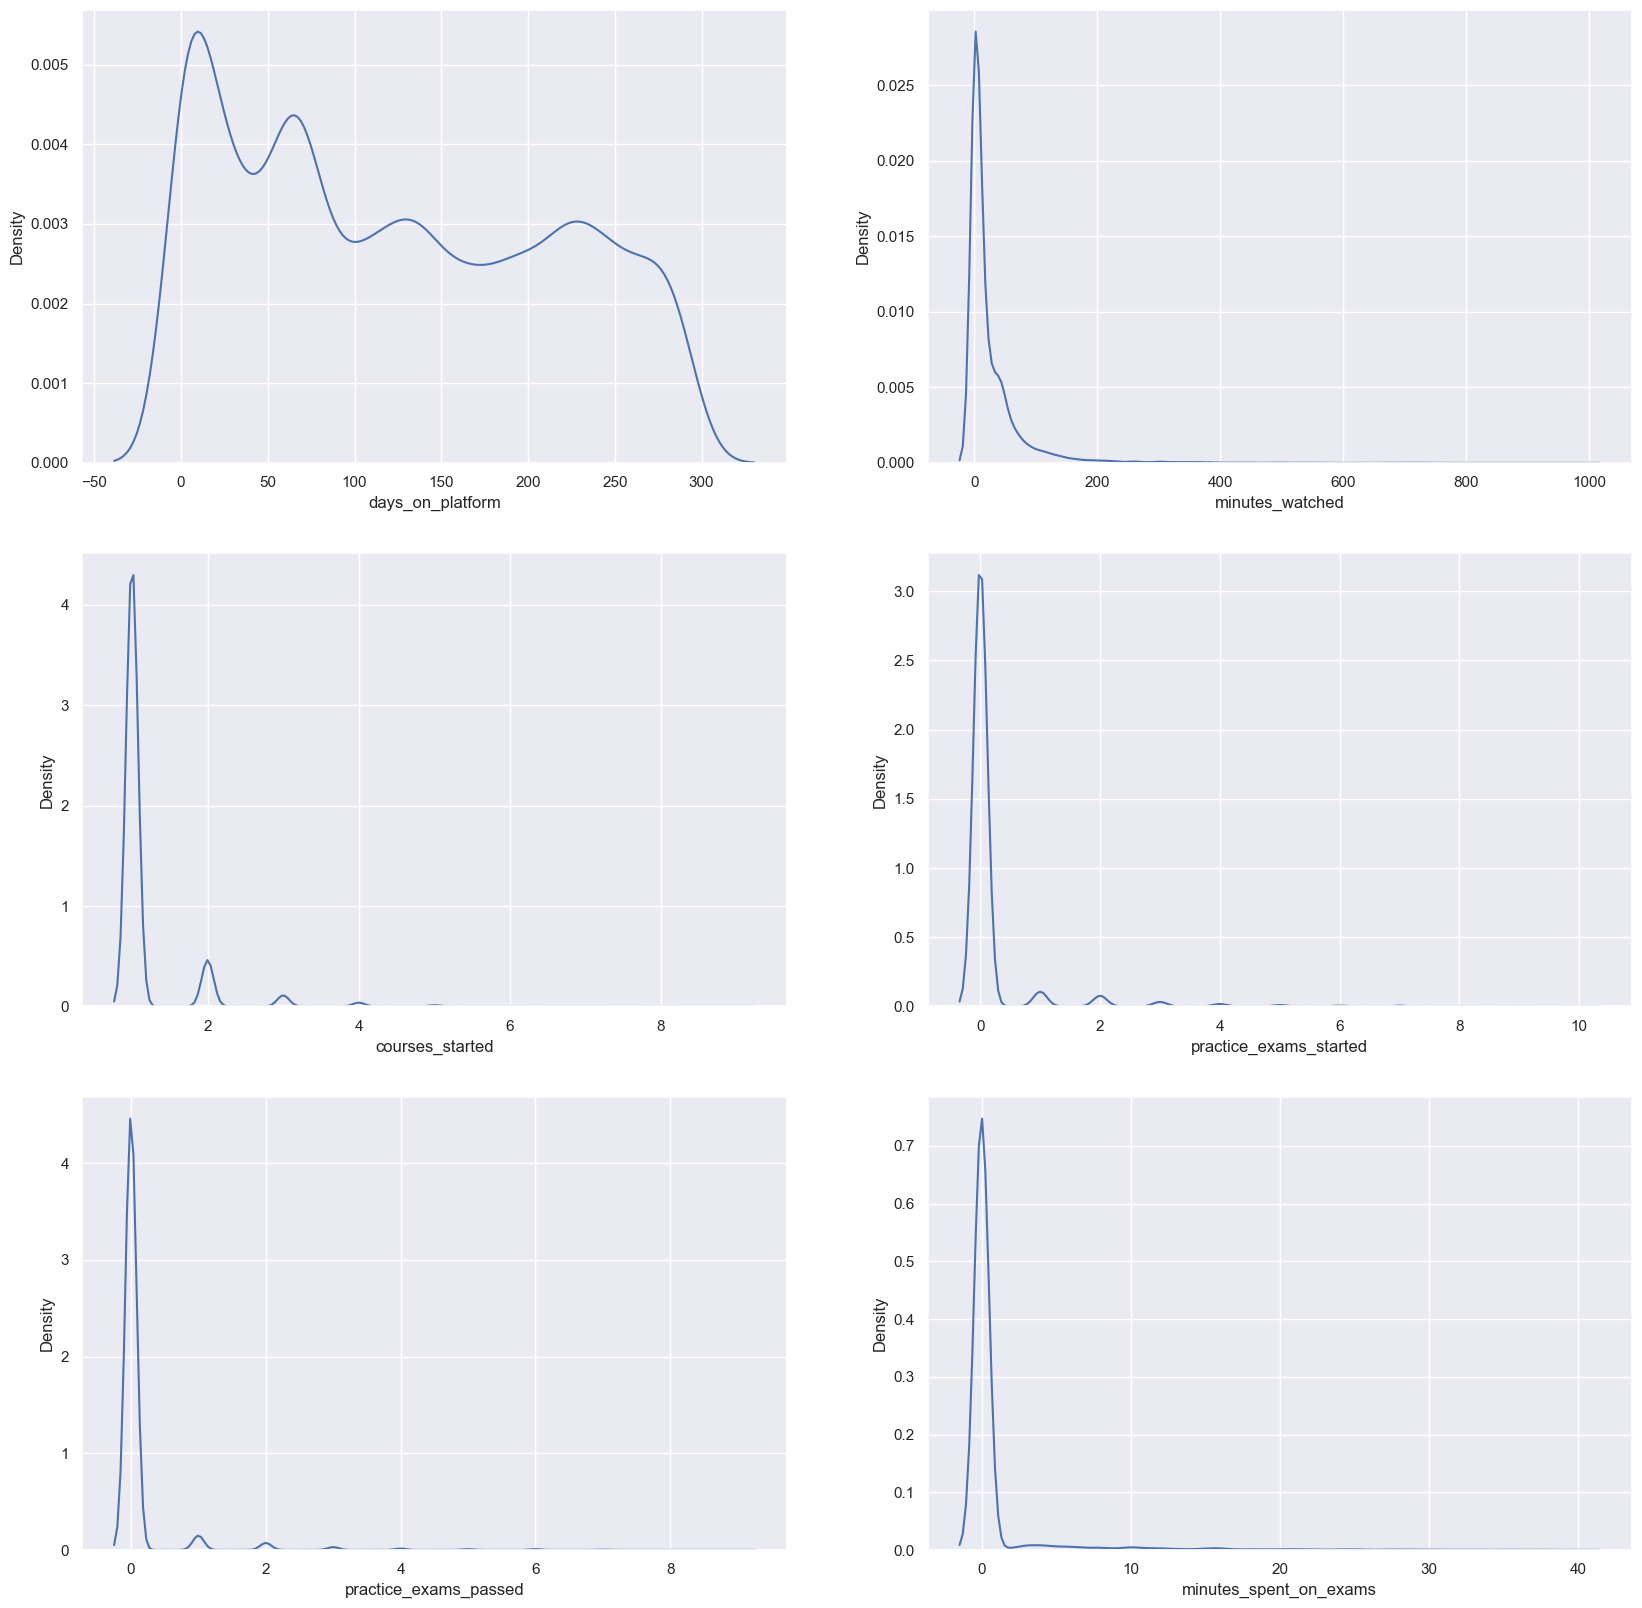

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
sns.kdeplot(data = data_no_outliers, x='days_on_platform', ax=axes[0,0])
sns.kdeplot(data = data_no_outliers, x='minutes_watched', ax=axes[0,1])
sns.kdeplot(data = data_no_outliers, x='courses_started', ax=axes[1,0])
sns.kdeplot(data = data_no_outliers, x='practice_exams_started', ax=axes[1,1])
sns.kdeplot(data = data_no_outliers, x='practice_exams_passed', ax=axes[2,0])
sns.kdeplot(data = data_no_outliers, x='minutes_spent_on_exams', ax=axes[2,1])

### Checking for Multicollinearity

In [8]:
# Filter only numeric columns
numeric_columns = data_no_outliers.select_dtypes(include=['number'])

In [11]:
# Calculate VIF for each numeric variable
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_columns.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_columns.values, i) for i in range(numeric_columns.shape[1])]

print(vif_data)

                 Variable        VIF
0        days_on_platform   2.494163
1         minutes_watched   1.814420
2         courses_started   3.504408
3  practice_exams_started  10.206234
4   practice_exams_passed   7.829732
5  minutes_spent_on_exams   3.355225
6               purchased   1.229006


In [12]:
# Remove feature with highest VIF value
data_no_mult = data_no_outliers.drop(['practice_exams_started'],axis=1)

In [13]:
# Inspect VIF values again to check none are no longer greater than 5
numeric_columns = data_no_mult.select_dtypes(include=['number'])
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_columns.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_columns.values, i) for i in range(numeric_columns.shape[1])]

print(vif_data)

                 Variable       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475


### Dealing with NaN Values

In [14]:
data_no_mult.isna().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [15]:
data_no_mult.loc[data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [16]:
# Replace NaN values with the country code of Namibia
data_no_mult['student_country'].fillna('NAM', inplace=True)

In [17]:
data_no_mult.isna().sum()

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

### Splitting the Data

In [19]:
X = data_no_mult.drop(columns=['purchased'])
y = data_no_mult['purchased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=365, stratify=y)

### Encoding the Data

In [21]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=170)

In [22]:
X_train['student_country_enc'] = enc.fit_transform(X_train['student_country'].to_numpy().reshape(-1, 1));

In [34]:
X_train.drop('student_country', axis=1, inplace=True)
X_train

,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
5718,218,1.6,2,0,0.00,69.0
3119,263,75.5,1,0,0.00,69.0
5440,222,44.4,1,0,0.00,84.0
11828,97,2.6,1,0,0.00,148.0
8454,162,1.0,1,0,0.00,80.0
...,...,...,...,...,...,...
15362,35,9.3,1,0,0.00,68.0
4413,239,2.2,1,0,0.00,53.0
14984,42,44.0,1,0,0.00,160.0
382,118,79.3,2,1,2.17,15.0


In [35]:
X_test.drop('student_country', axis=1, inplace=True)
X_test

,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams
2018,284,0.7,1,0,0.0
13491,66,65.7,2,0,0.0
14708,48,65.4,4,0,0.0
5627,219,1.4,1,0,0.0
15104,39,0.3,1,0,0.0
...,...,...,...,...,...
5424,222,6.6,1,0,0.0
4063,245,125.5,2,0,0.0
694,71,47.6,3,4,10.2
17742,0,1.2,1,0,0.0


In [37]:
X_train = X_train.values.astype(float)
y_train = y_train.values.astype(int)
X_test = X_test.values.astype(float)
y_test = y_test.values.astype(int)

# Creating a Logistic Regression Model

In [39]:
# Fit logistic regression model
log_reg = sm.Logit(y_train, sm.add_constant(X_train))
log_reg_results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.150289
         Iterations 10


In [40]:
# Output summary of the model
print(log_reg_results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14093
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 May 2024   Pseudo R-squ.:                  0.5111
Time:                        14:32:23   Log-Likelihood:                -2119.1
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0543      0.118     -8.961      0.000      -1.285      -0.824
x1            -0.0666      0.002    -30.565      0.000      -0.071      -0.062
x2             0.0127      0.001     17.761      0.0

In [41]:
# Predict outcomes for the test data
y_pred_prob = log_reg_results.predict(sm.add_constant(X_test))
y_pred = np.where(y_pred_prob <= 0.5, 0, 1)

ValueError: shapes (3526,6) and (7,) not aligned: 6 (dim 1) != 7 (dim 0)

In [ ]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Creating a K-Nearest Neighbors Model

# Creating a Support Vector Machines Model

# Creating a Decision Trees Model

# Creating a Random Forests Model